In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

import warnings
warnings.filterwarnings('ignore')

# Functions

In [172]:
def plot_graph(df, x_col = "Date", y_col = "Close", title = "S&P 500",
                        xlabel = 'Year', ylabel = 'Close value', start = "", end = ""):
    plt.figure(figsize=(10, 7))
    plt.plot(df[x_col], df[y_col])
    plt.title(title,fontsize=15)
    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    plt.show()
    return df

def plot_diff_series(df, x_col = "Date", y_col = "Log_Close", periods=365, xlabel= "Year", ylabel = 'Close value change',
                    title = "Differentiated Series Yearly"):
    df_diff = df.copy()
    df_diff = df_diff.set_index(x_col)
    df_diff=df_diff.diff(periods=periods)
    df_diff=df_diff.dropna() 

    plt.figure(figsize=(10, 7))
    plt.plot(df_diff.index, df_diff[y_col])
    plt.title(title,fontsize=15)
    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    return df_diff

def decompose_time_series(df, x_col = "Date", y_col = "Log_Close", period = 365):
    decomposition = seasonal_decompose(df[y_col], model='additive', period=period)

    plt.figure(figsize=(10, 7))

    plt.subplot(411)
    plt.plot(df[x_col],df[y_col], label='Original')
    plt.legend(loc='upper left')
    plt.title('Original Series')

    plt.subplot(412)
    plt.plot(df[x_col],decomposition.trend, label='Trend')
    plt.legend(loc='upper left')
    plt.title('Trend Component')

    plt.subplot(413)
    plt.plot(df[x_col],decomposition.seasonal, label='Seasonality')
    plt.legend(loc='upper left')
    plt.title('Seasonal Component')

    plt.subplot(414)
    plt.plot(df[x_col],decomposition.resid, label='Residuals')
    plt.legend(loc='upper left')
    plt.title('Residual Component')

    plt.tight_layout()
    plt.show()
    df_out = pd.DataFrame({"Date": sp500["Date"], "seasonal": decomposition.seasonal,
                          "trend": decomposition.trend, "resid":decomposition.resid})
    return df_out

def make_full_dates_df(sp500):
    full_sp500 = pd.DataFrame({
        "Date": pd.date_range(sp500["Date"].iloc[0], sp500["Date"].iloc[-1], freq="D")
    })
    
    full_sp500 = full_sp500.merge(sp500, on="Date", how="left")
    full_sp500["Open"].ffill(inplace=True)
    full_sp500["Close"].ffill(inplace=True)
    full_sp500["Adj Close"].ffill(inplace=True)
    full_sp500["Volume"].fillna(0, inplace=True)
    full_sp500["Low"].fillna(full_sp500["Close"], inplace=True)
    full_sp500["High"].fillna(full_sp500["Close"], inplace=True)
    
    return full_sp500

# Data loading

In [173]:
sp500 = pd.read_csv("SPY1950.csv")
sp500["Date"] = pd.to_datetime(sp500["Date"], format = "%d/%m/%Y")
sp500 = make_full_dates_df(sp500)

In [174]:
sp500.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1950-01-03,16.66,16.66,16.66,16.66,16.66,1260000.0
1,1950-01-04,16.85,16.85,16.85,16.85,16.85,1890000.0
2,1950-01-05,16.93,16.93,16.93,16.93,16.93,2550000.0
3,1950-01-06,16.98,16.98,16.98,16.98,16.98,2010000.0
4,1950-01-07,16.98,16.98,16.98,16.98,16.98,0.0


# Plotting the data

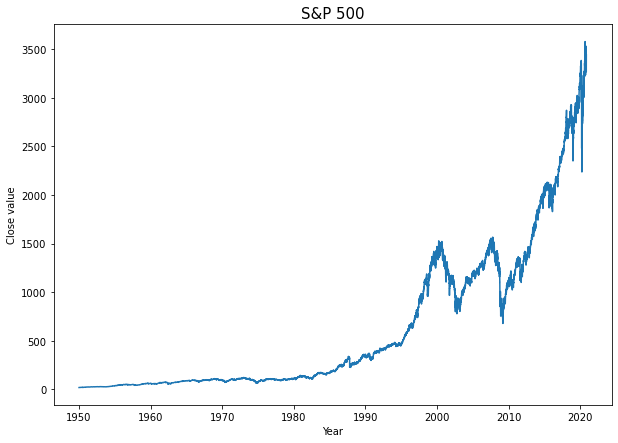

In [175]:
plot_graph(sp500);

this graph is rather exponential, lets take a look at the Log Close value

In [176]:
sp500["Log_Close"] = np.log(sp500["Close"])

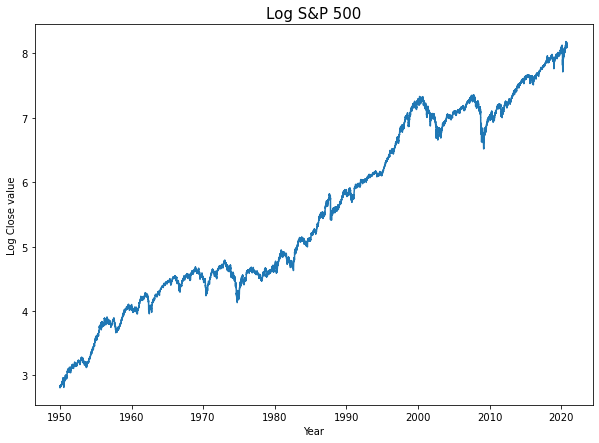

In [177]:
plot_graph(sp500, y_col= "Log_Close", ylabel = "Log Close value" , title = "Log S&P 500");

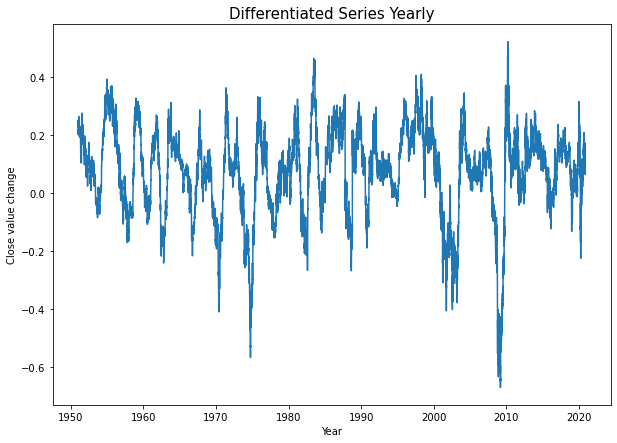

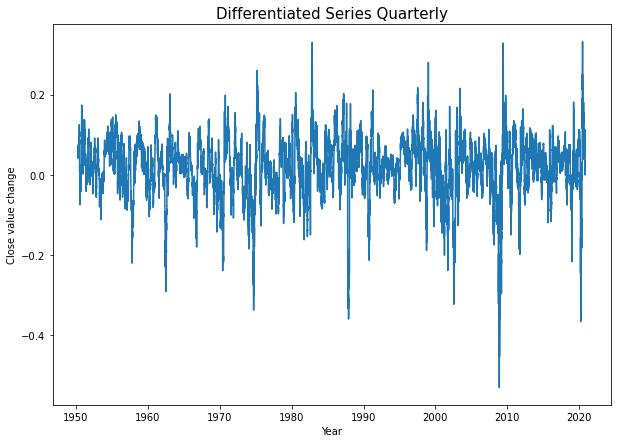

In [178]:
sp500_diff_Y = plot_diff_series(sp500)
sp500_diff_Q = plot_diff_series(sp500, periods=365//4, title = "Differentiated Series Quarterly")

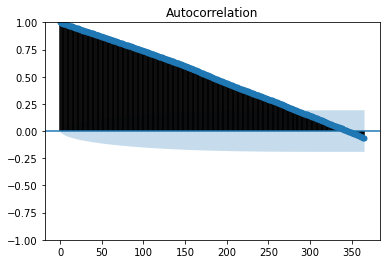

In [179]:
tsaplots.plot_acf(sp500_diff_Y["Log_Close"], lags=365);

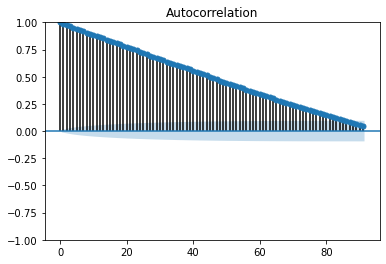

In [180]:
tsaplots.plot_acf(sp500_diff_Q["Log_Close"], lags=365//4);

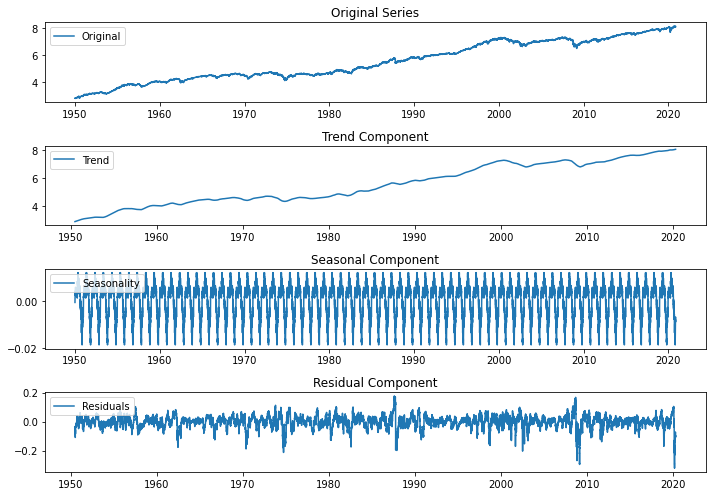

In [181]:
decomposition = decompose_time_series(sp500, y_col = "Log_Close", period = 365)

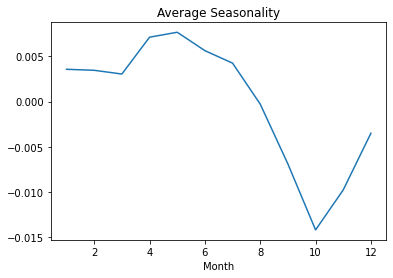

In [182]:
decomposition["Month"] = decomposition["Date"].dt.month
plt.plot(decomposition.groupby("Month")["seasonal"].mean())
plt.xlabel("Month")
plt.title("Average Seasonality")
plt.plot();

Defalut

16:05:35 - cmdstanpy - INFO - Chain [1] start processing
16:05:53 - cmdstanpy - INFO - Chain [1] done processing


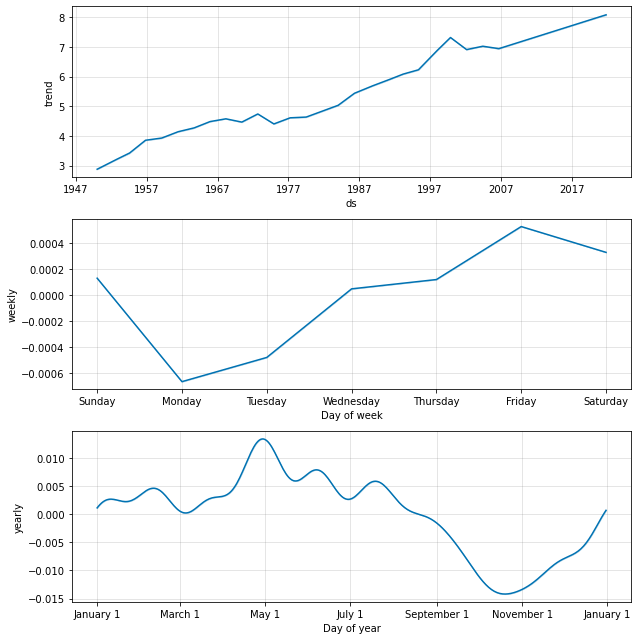

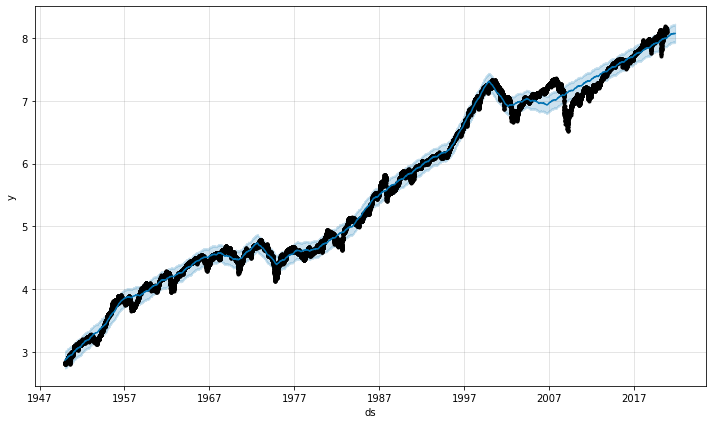

In [183]:
sp500_prophet = sp500.rename({"Date": "ds", "Log_Close": "y"}, axis =1)
m = Prophet()
m.fit(sp500_prophet)
future_dates = m.make_future_dataframe(periods=365)
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

Holidays

16:06:01 - cmdstanpy - INFO - Chain [1] start processing
16:06:25 - cmdstanpy - INFO - Chain [1] done processing


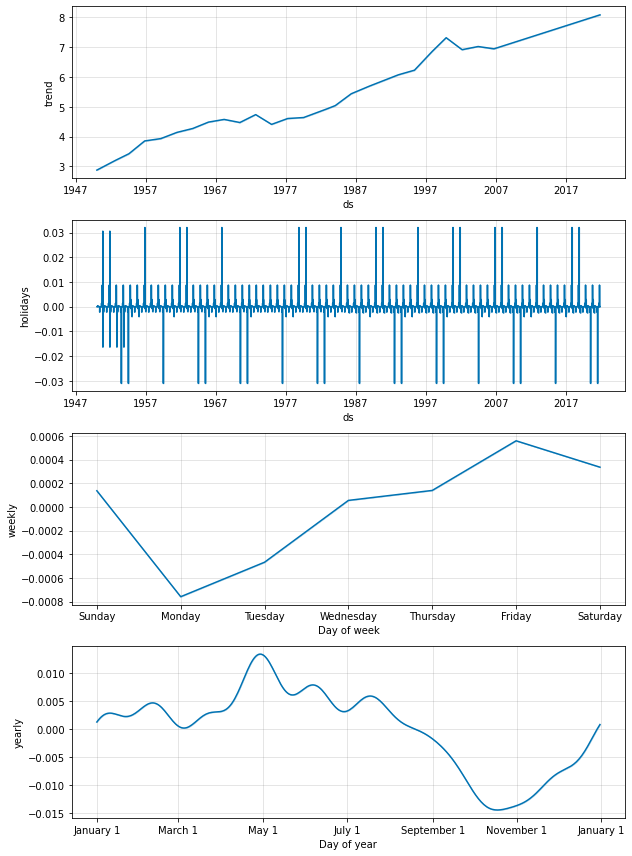

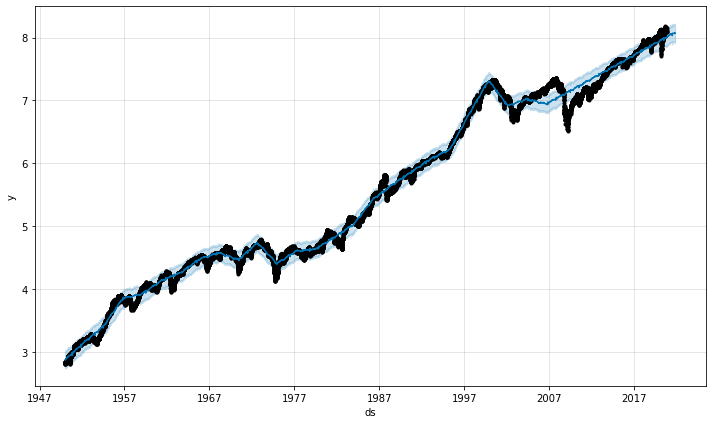

In [184]:
m = Prophet()
m.add_country_holidays(country_name='US')
m.fit(sp500_prophet)
future_dates = m.make_future_dataframe(periods=365)
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

Volume + changepoint_range 0.95

16:49:00 - cmdstanpy - INFO - Chain [1] start processing
16:49:14 - cmdstanpy - INFO - Chain [1] done processing


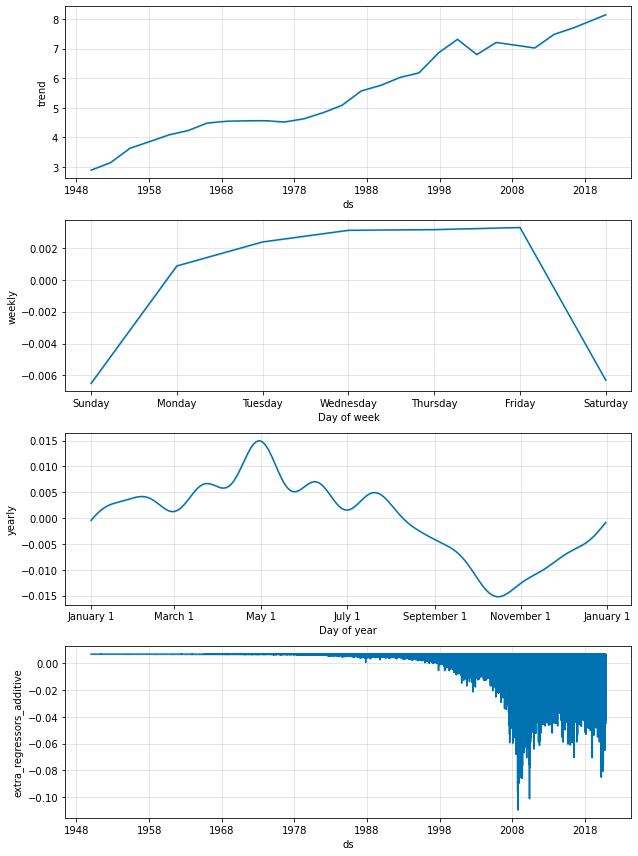

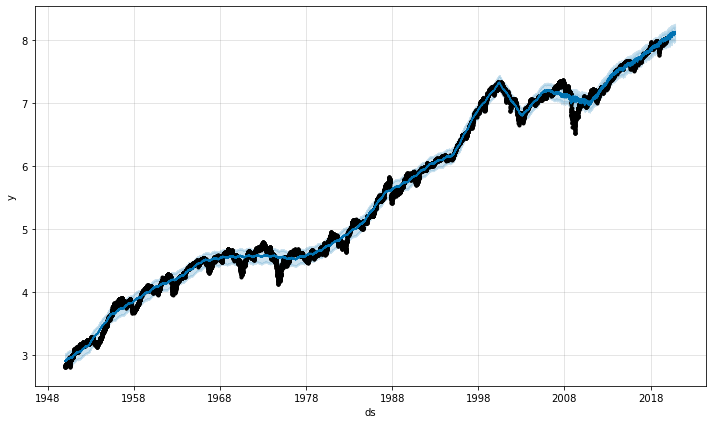

In [221]:
m = Prophet(changepoint_range = 0.95)
m.add_regressor("Volume")
m.fit(sp500_prophet[:-365])
future_dates = m.make_future_dataframe(periods=365)
future_dates['Volume'] = sp500_prophet['Volume']
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

with monthly seasonality

16:07:19 - cmdstanpy - INFO - Chain [1] start processing
16:07:39 - cmdstanpy - INFO - Chain [1] done processing


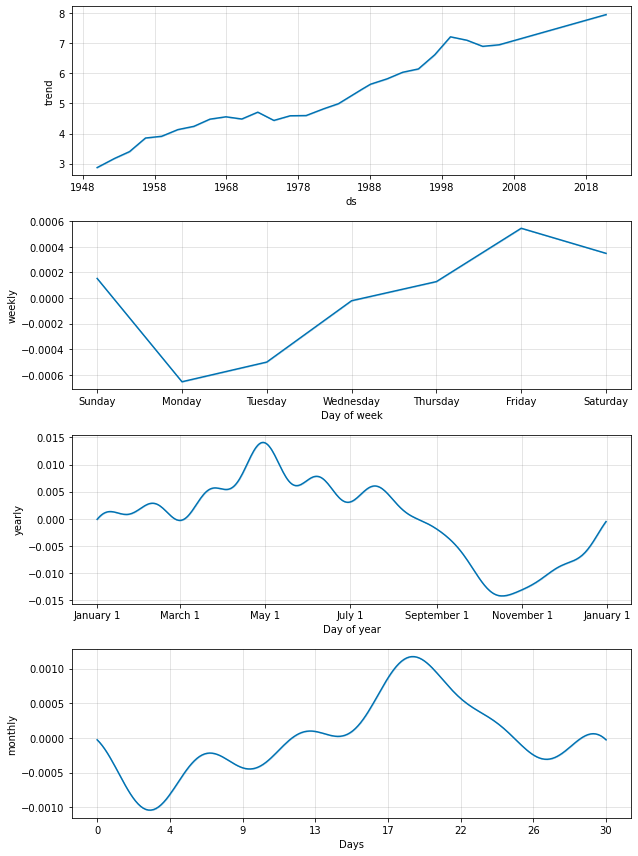

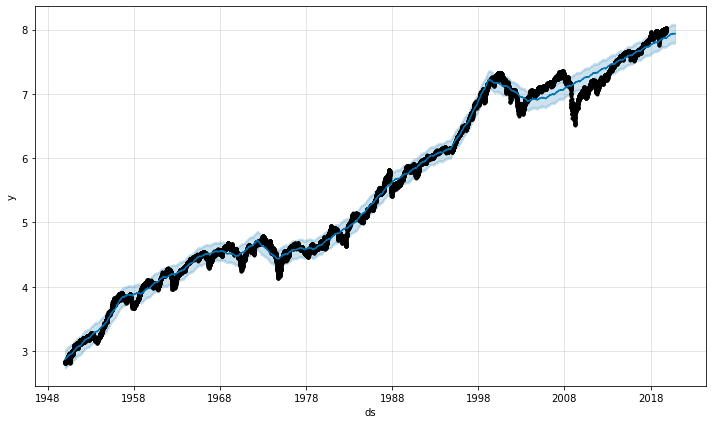

In [187]:
m = Prophet()
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(sp500_prophet[:-365])
future_dates = m.make_future_dataframe(periods=365)
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

In [188]:
def years_until_next_election(year):
    return (4 - (year % 4)) % 4

def fill_party_periods(periods, party):
    return {year: party for start, end in periods for year in range(start, end)}

def generate_presidential_parties():
    democrat_periods = [(1940, 1952), (1961, 1969), (1977, 1981), (1993, 2001), (2009, 2017), (2021, 2024)]
    republican_periods = [(1953, 1961), (1969, 1977), (1981, 1993), (2001, 2009), (2017, 2021)]
    parties = {}
    parties.update(fill_party_periods(democrat_periods, 'Democrat'))
    parties.update(fill_party_periods(republican_periods, 'Republican'))
    return parties

def generate_president_party_dataset(last_year=2023):
    presidential_parties = generate_presidential_parties()
    start_date = '1940-01-01'
    end_date = f'{last_year}-12-31'
    dates = pd.date_range(start=start_date, end=end_date, freq='D')

    data = {'Date': [], 'Years Until Next US Election': [], 'Presidential Party': []}
    for date in dates:
        year = date.year
        party = presidential_parties.get(year, 'Unknown')
        data['Date'].append(date)
        data['Years Until Next US Election'].append(years_until_next_election(year))
        data['Presidential Party'].append(party)
    
    df = pd.DataFrame(data)
    return df

president_party_df = generate_president_party_dataset()
president_party_df['Democrat'] = president_party_df['Presidential Party'] == 'Democrat'
president_party_df['Republican'] = president_party_df['Presidential Party'] == 'Republican'
president_party_df['Democrat'] = president_party_df['Democrat'].astype(int)
president_party_df['Republican'] = president_party_df['Republican'].astype(int)


In [193]:
sp500_prophet_enriched = sp500_prophet.merge(president_party_df[['Date', 'Years Until Next US Election', 
                                                                 'Democrat', 'Republican']],
                                             left_on='ds', right_on='Date', how='left')

Democrat party regressor

16:07:47 - cmdstanpy - INFO - Chain [1] start processing
16:08:04 - cmdstanpy - INFO - Chain [1] done processing


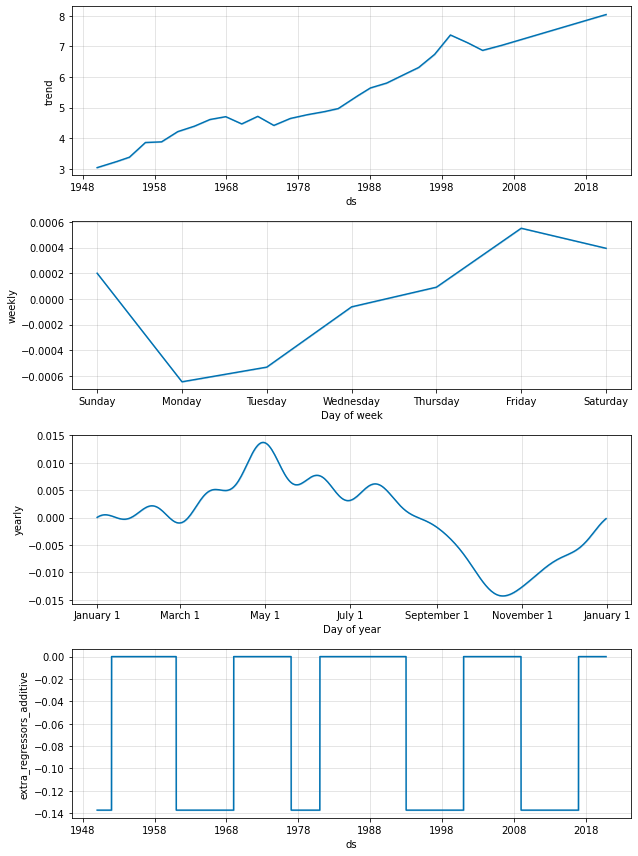

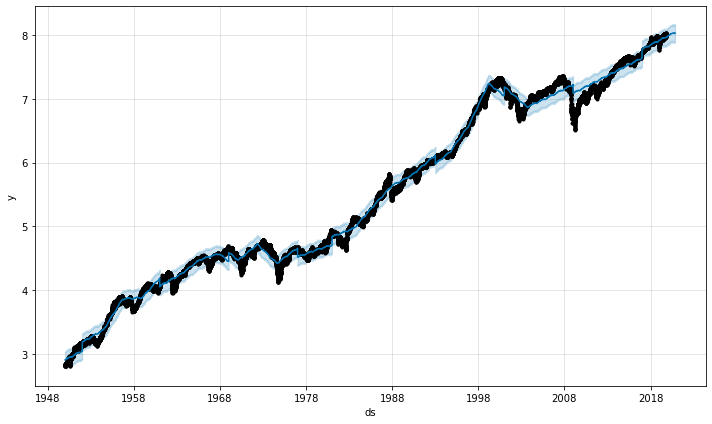

In [190]:
m = Prophet()
# m.add_regressor("Years Until Next US Election")
m.add_regressor("Democrat")
m.fit(sp500_prophet_enriched[:-365])
future_dates = m.make_future_dataframe(periods=365)
future_dates['Democrat'] = sp500_prophet_enriched['Democrat']
# future_dates['Years Until Next US Election'] = sp500_prophet_enriched['Years Until Next US Election']
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

In [ ]:
Democrat Republican, seasonality

16:15:22 - cmdstanpy - INFO - Chain [1] start processing
16:15:53 - cmdstanpy - INFO - Chain [1] done processing


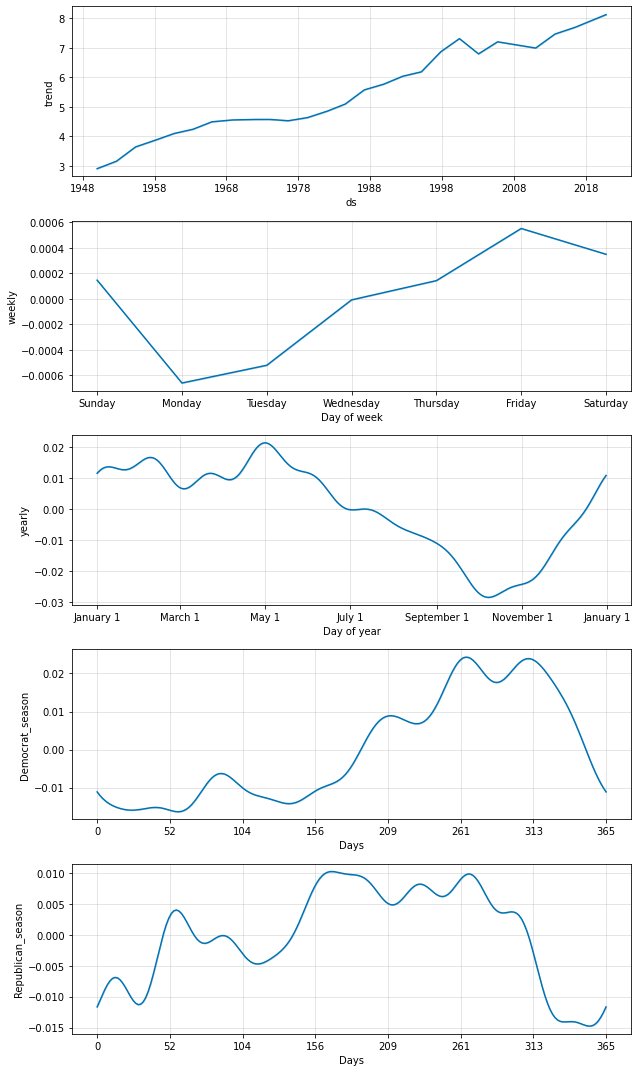

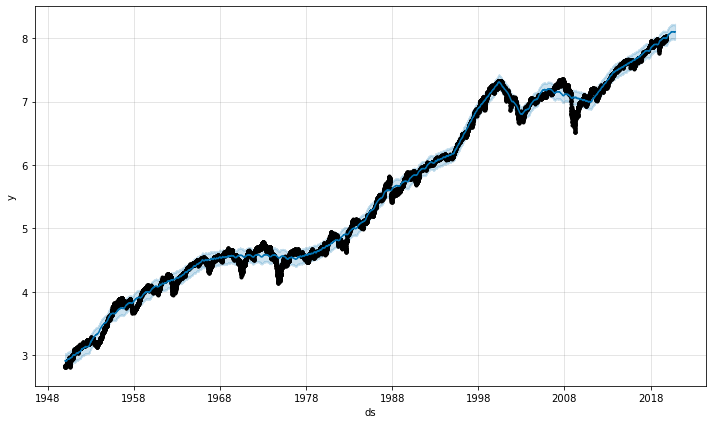

In [195]:
m = Prophet(changepoint_range = 0.95)
# m.add_regressor("Years Until Next US Election")
m.add_seasonality(name='Democrat_season', period=365, fourier_order=10, condition_name='Democrat')
m.add_seasonality(name='Republican_season', period=365, fourier_order=10, condition_name='Republican')
m.fit(sp500_prophet_enriched[:-365])
future_dates = m.make_future_dataframe(periods=365)
future_dates['Democrat'] = sp500_prophet_enriched['Democrat']
future_dates['Republican'] = sp500_prophet_enriched['Republican']
# future_dates['Years Until Next US Election'] = sp500_prophet_enriched['Years Until Next US Election']
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

cross validation

In [204]:
cutoffs = pd.to_datetime([f'{year}-01-01' for year in [i*5 + 1960 for i in range(12)]])
df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', parallel="processes")

  0%|          | 0/12 [00:00<?, ?it/s]

16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing
16:24:32 - cmdstanpy - INFO - Chain [1] start processing
16:24:39 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing
16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:23 - cmdstanpy - INFO - Chain [1] done processing
16:25:25 - cmdstanpy - INFO - Chain [1] start processing
16:25:42 - cmdstanpy - INFO - Chain [1] done processing
16:25:45 - cmdstanpy - INFO - Chain [1] start processing
16:26:04 - cmdstanpy - INFO - Chain [1] done processing
16:26:07 - cmdstanpy - INFO - Chain [1] start processing
16:26:34 - cmdstanpy - INFO - Chain [1]

In [220]:
performance_metrics(df_cv, rolling_window=0)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,0.004991,0.070647,0.047767,0.008133,0.006869,0.008173,0.833333
1,2 days,0.005055,0.071097,0.049558,0.008514,0.007680,0.008553,0.833333
2,3 days,0.005737,0.075745,0.052922,0.008994,0.007580,0.009034,0.833333
3,4 days,0.005858,0.076537,0.054681,0.009312,0.007859,0.009354,0.750000
4,5 days,0.005991,0.077401,0.055563,0.009406,0.007558,0.009450,0.833333
...,...,...,...,...,...,...,...,...
360,361 days,0.075474,0.274725,0.216659,0.039015,0.028109,0.040147,0.416667
361,362 days,0.075554,0.274872,0.216065,0.038965,0.027944,0.040112,0.500000
362,363 days,0.075736,0.275201,0.216113,0.038881,0.026647,0.040012,0.583333
363,364 days,0.076483,0.276555,0.217155,0.039030,0.026840,0.040172,0.333333
